In [1]:
!pip install keras-tuner

In [2]:
import os,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D

from keras import regularizers
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [3]:
%load_ext autotime
RANDOM_STATE = 42

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

time: 1.39 s


In [5]:
seed = 7
np.random.seed(seed)

time: 112 ms


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 70.4 ms


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

time: 5.77 s


In [8]:
tf.test.is_built_with_cuda()

True

time: 69.6 ms


In [9]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

time: 68.8 ms


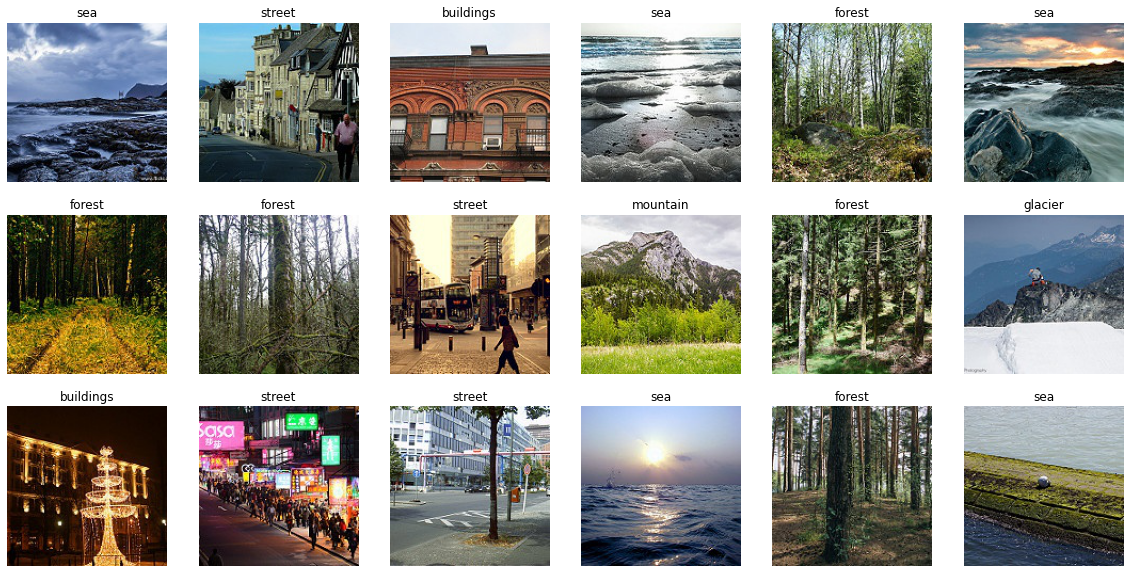

time: 1.59 s


In [10]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/',target_class=class_name)

In [11]:
train_dir = "/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/"
test_dir = "/home/anjir29/Desktop/America/data/archive/seg_test/seg_test/"
val_dir ="/home/anjir29/Desktop/America/data/archive/seg_val/seg_test/"

time: 463 µs


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
time: 789 ms


In [13]:
LOG_DIR = f"{int(time.time())}"

time: 418 µs


In [14]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

time: 82.5 ms


In [15]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

time: 159 ms


In [16]:
def build_model(hp):
    input_shape=(32, 32, 3)
    X_input = Input(input_shape)

    X = ZeroPadding2D((1, 1))(X_input)

    X = Conv2D(hp.Choice('s1_filter_size_1', values=[16,32,64,128,256,512],default=16), (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=2, block='a', s=1)
    X = identity_block(X, 3, [hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=2, block='b')
    X = identity_block(X, 3, [hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='b')
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='c')
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='b')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='c')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='d')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='e')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=5, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=5, block='b')
    X = identity_block(X, 3, [hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X= Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0))(X)
    X = Flatten()(X)
    X=Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64), activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)), name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64), activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)), name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X= Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0))(X)
    X = Dense(6,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
    opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4, 1e-5],default=1e-2))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                    optimizer=opt,
                                    metrics=['accuracy'])
    
    return model


time: 136 ms


In [17]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR,
    project_name='Hp_ResNet50_Intel')

tuner.search_space_summary()


Search space summary
Default search space size: 20
s1_filter_size_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s2_filter_size_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s2_filter_size_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s2_filter_size_3 (Choice)
{'default': 128, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s3_filter_size_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s3_filter_size_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s3_filter_size_3 (Choice)
{'default': 128, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s4_filter_size_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512], 'ordered': True}
s4_filter_size_2 (C

In [18]:
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
tuner.search(training_data,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=30,
             batch_size=64,
             callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
             validation_data=validation_data)


Trial 67 Complete [00h 01m 15s]
val_accuracy: 0.22291666269302368

Best val_accuracy So Far: 0.6850000023841858
Total elapsed time: 01h 05m 56s

Search: Running Trial #68

Hyperparameter    |Value             |Best Value So Far 
s1_filter_size_1  |512               |16                
s2_filter_size_1  |64                |16                
s2_filter_size_2  |128               |128               
s2_filter_size_3  |512               |32                
s3_filter_size_1  |64                |64                
s3_filter_size_2  |128               |256               
s3_filter_size_3  |32                |64                
s4_filter_size_1  |512               |256               
s4_filter_size_2  |128               |64                
s4_filter_size_3  |64                |256               
s5_filter_size_1  |128               |16                
s5_filter_size_2  |256               |64                
s5_filter_size_3  |256               |256               
dp_size_1         |0.6        

KeyboardInterrupt: 

time: 1h 6min 3s


In [19]:
tuner.results_summary()
with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

Results summary
Results in 1624446367/Hp_ResNet50_Intel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
s1_filter_size_1: 16
s2_filter_size_1: 16
s2_filter_size_2: 128
s2_filter_size_3: 32
s3_filter_size_1: 64
s3_filter_size_2: 256
s3_filter_size_3: 64
s4_filter_size_1: 256
s4_filter_size_2: 64
s4_filter_size_3: 256
s5_filter_size_1: 16
s5_filter_size_2: 64
s5_filter_size_3: 256
dp_size_1: 0.5
dense_size_1: 512
wd_size_1: 0.0
dense_size_2: 256
wd_size_2: 0.2
dp_size_2: 0.1
learning_rate: 0.001
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 90c270c338b78ef4171e0ce76e8bd4db
Score: 0.6850000023841858
Trial summary
Hyperparameters:
s1_filter_size_1: 512
s2_filter_size_1: 64
s2_filter_size_2: 128
s2_filter_size_3: 512
s3_filter_size_1: 64
s3_filter_size_2: 128
s3_filter_size_3: 32
s4_filter_size_1: 512
s4_filter_size_2: 128
s4_filter_size_3: 64
s5_filter_size_1: 128
s5_filter_size_2: 256
s5_filte

In [20]:
new_model = tuner.get_best_hyperparameters()[0]

time: 524 µs


In [21]:
model = tuner.hypermodel.build(new_model)

time: 1.03 s


In [22]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 16)   2368        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 16)   64          conv1[0][0]                      
___________________________________________________________________________________________

In [23]:
hist=model.fit(training_data,
      batch_size=64,
      epochs=100,
      validation_data=validation_data,
      callbacks=[my_callbacks])

Epoch 1/100
439/439 [==============================] - 19s 34ms/step - loss: 17.2407 - accuracy: 0.3304 - val_loss: 1.2964 - val_accuracy: 0.4967
Epoch 2/100
439/439 [==============================] - 13s 31ms/step - loss: 1.2187 - accuracy: 0.5480 - val_loss: 1.1251 - val_accuracy: 0.5950
Epoch 3/100
439/439 [==============================] - 14s 32ms/step - loss: 1.0796 - accuracy: 0.6153 - val_loss: 0.9964 - val_accuracy: 0.6392
Epoch 4/100
439/439 [==============================] - 13s 30ms/step - loss: 1.0128 - accuracy: 0.6479 - val_loss: 1.3503 - val_accuracy: 0.5188
Epoch 5/100
439/439 [==============================] - 14s 31ms/step - loss: 0.9651 - accuracy: 0.6721 - val_loss: 1.0178 - val_accuracy: 0.6242
Epoch 6/100
439/439 [==============================] - 13s 29ms/step - loss: 0.8770 - accuracy: 0.6982 - val_loss: 0.9771 - val_accuracy: 0.6625
Epoch 7/100
439/439 [==============================] - 13s 30ms/step - loss: 0.8541 - accuracy: 0.7109 - val_loss: 1.2029 - val_a

In [25]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 0s 27ms/step - loss: 0.9951 - accuracy: 0.5938
time: 110 ms
